# Using Player rating data to produce a tensorflow recommendation engine

## Functions in file from: https://developers.google.com/machine-learning/recommendation/labs/movie-rec-programming-exercise

# Scanning Data

In [6]:
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import seaborn as sns
import tensorflow.compat.v1 as tf

In [7]:
# Install Altair and activate its colab renderer.
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git -q
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")

Installing Altair...


You should consider upgrading via the 'c:\users\18053\anaconda3\python.exe -m pip install --upgrade pip' command.


Done installing Altair.


In [8]:
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

In [9]:
pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

In [10]:
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

Instructions for updating:
non-resource variables are not supported in the long term


In [11]:
df = pd.read_csv('player_ratings.csv')

In [12]:
df.head()

,game_id,user,rating
0,1,jackcres,10.0
1,1,FuManchu,10.0
2,1,HankM,10.0
3,1,jonnypolite,10.0
4,1,pwotruba,10.0


In [13]:
num_ratings = pd.pivot_table(df, index=['user'], values=['rating'], aggfunc='count')
num_ratings.reset_index(inplace=True)
num_ratings.columns = ['user','ratings']
num_ratings.sort_values('ratings', ascending=False).head(10)

,user,ratings
282439,stoneart69,377
271005,ryansmum2008,375
36706,Doel,375
66153,JasonSaastad,374
106101,Pandorzecza,373
52633,Gibmaatsuki,372
233284,leffe dubbel,372
297318,we3die,361
295537,vincivader,350
259357,pete100,348


In [14]:
num_ratings[num_ratings['ratings'] > -1].shape[0], num_ratings[num_ratings['ratings'] > 10].shape[0]

(304441, 108991)

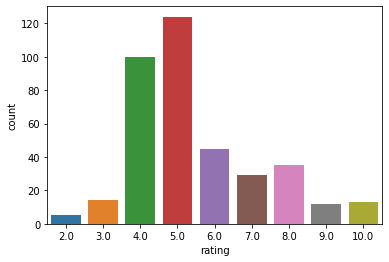

In [15]:
sns.countplot(data=df[df['user'] == 'stoneart69'], x = 'rating')

In [16]:
df['rating_int'] = df['rating'].astype(int)

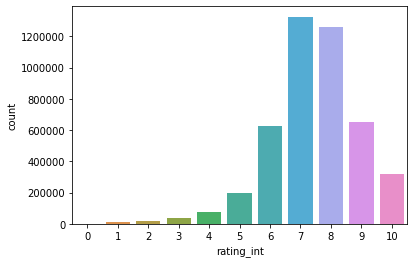

In [17]:
sns.countplot(data = df, x = 'rating_int')

In [18]:
df['approve'] = np.where(df['rating'] >= 7, 1, 0)

# Recommender System Setup

In [19]:
# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

In [20]:
ratings = df.merge(num_ratings, on ='user')
ratings = ratings[ratings['ratings'] > 10]
ratings.head()

,game_id,user,rating,rating_int,approve,ratings
0,1,jackcres,10.0,10,1,31
1,1035,jackcres,8.0,8,1,31
2,1041,jackcres,8.0,8,1,31
3,11,jackcres,6.0,6,0,31
4,110327,jackcres,6.0,6,0,31


In [21]:
from collections import defaultdict

def return_negative_one():
    return -1
    
user_dict = defaultdict(return_negative_one)
game_dict = defaultdict(return_negative_one)

In [22]:
i = 0
for u in ratings['user'].unique():
    user_dict[u] = i
    i += 1

In [23]:
i = 0
for u in ratings['game_id'].unique():
    game_dict[u] = i
    i += 1

In [24]:
ratings['user_idx'] = ratings['user'].apply(lambda x: user_dict[x])
ratings['game_idx'] = ratings['game_id'].apply(lambda x: game_dict[x])
ratings.head()

,game_id,user,rating,rating_int,approve,ratings,user_idx,game_idx
0,1,jackcres,10.0,10,1,31,0,0
1,1035,jackcres,8.0,8,1,31,0,1
2,1041,jackcres,8.0,8,1,31,0,2
3,11,jackcres,6.0,6,0,31,0,3
4,110327,jackcres,6.0,6,0,31,0,4


In [25]:
ratings.dtypes

game_id         int64
user           object
rating        float64
rating_int      int32
approve         int32
ratings         int64
user_idx        int64
game_idx        int64
dtype: object

(3801461, 108990, 108991)

In [27]:
#@title Solution
def build_rating_sparse_tensor(ratings_df):
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
  Returns:
    a tf.SparseTensor representing the ratings matrix.
  """
  indices = ratings_df[['user_idx', 'game_idx']].values
  values_ = ratings_df['rating_int'].values
  return tf.SparseTensor(
      indices=indices,
      values=values_,
      dense_shape=[ratings_df['user_idx'].nunique(), ratings_df['game_idx'].nunique()])

In [28]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.gather_nd(
      tf.matmul(user_embeddings, movie_embeddings, transpose_b=True),
      sparse_ratings.indices)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

In [29]:
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [66]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
  """
  Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  print(A_train.indices)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_idx": U,
      "game_idx": V
  }
  return CFModel(embeddings, train_loss, [metrics])

In [67]:
train_ratings, test_ratings = split_dataframe(ratings)
# SparseTensor representation of the train and test datasets.
A_train = build_rating_sparse_tensor(train_ratings)
A_test = build_rating_sparse_tensor(test_ratings)

Tensor("SparseTensor_8/indices:0", shape=(3421315, 2), dtype=int64)
 iteration 350: train_error=1.375319, test_error=1.4656414

[{'train_error': 1.375319, 'test_error': 1.4656415}]

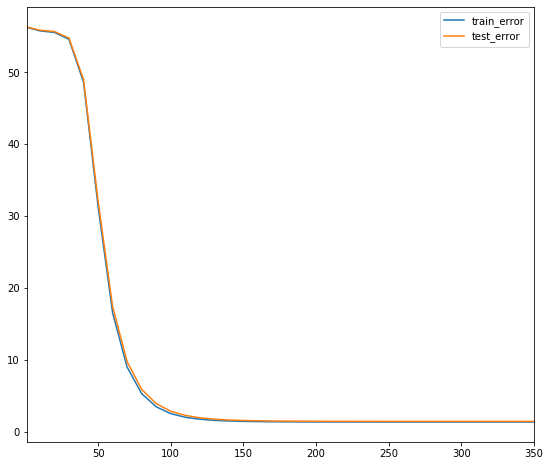

In [68]:
# Build the CF model and train it.
model = build_model(ratings, embedding_dim=10, init_stddev=0.5)
model.train(num_iterations=350, learning_rate=40., plot_results = True)

# Testing Recommender Performance

In [41]:
#itle Solution
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [42]:
import sqlite3
con = sqlite3.connect('bgg.db')
cur = con.cursor()

In [43]:
#results = cur.execute('SELECT * FROM TOP_GAMES_FULL')
results = cur.execute('PRAGMA table_info(TOP_GAMES_FULL)')
results = results.fetchall()
result_li = [r for r in results]
column_li = []
for r in result_li:
    column_li.append(r[1])

print(column_li)

['id', 'title', 'year', 'min_players', 'max_players', 'avg_rating', 'avg_bayes_rating', 'std', 'ratings', 'weight', 'play_time']


In [44]:
results = cur.execute('SELECT * FROM TOP_GAMES_FULL')
results = results.fetchall()
result_li = [r for r in results]
df = pd.DataFrame(result_li, columns = column_li)
df.head()

,id,title,year,min_players,max_players,avg_rating,avg_bayes_rating,std,ratings,weight,play_time
0,174430,gloomhaven,2017,1,4,8.76798,8.53089,1.63005,45304,3.8673,120
1,161936,pandemic_legacy_season_1,2015,2,4,8.60479,8.45273,1.56467,43525,2.836,60
2,224517,brass_birmingham,2018,2,4,8.66929,8.406,1.24659,22694,3.9084,120
3,167791,terraforming_mars,2016,1,5,8.4247,8.27852,1.38438,69921,3.244,120
4,291457,gloomhaven_jaws_lion,2020,1,4,8.7573,8.2579,1.40857,12633,3.559,120


In [45]:
df['game_idx'] = df['id'].apply(lambda x: game_dict[int(x)])
games = df[df['game_idx'] >= 0]
games = games[['game_idx', 'title', 'year', 'weight', 'play_time', 'ratings']]

In [46]:
def game_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for movie ids that match the given substring.
  ids =  games.loc[games['title'].str.contains(title_substring), ['game_idx']].values
  ids = list(ids.flatten())
  titles = games.loc[games['game_idx'].isin(ids), 'title'].values
  if len(titles) == 0:
    raise ValueError("Found no games with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching game. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  movie_id = ids[0]
  scores = compute_scores(
      model.embeddings["game_idx"][movie_id], model.embeddings["game_idx"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': games['title']
      #'genres': movies['all_genres']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

In [47]:
game_neighbors(model, "bohnanza", COSINE, k=6)

Nearest neighbors of : bohnanza.


,cosine score,titles
7,1.000000,star_wars_rebellion
15,0.999964,7_wonders_duel
62,0.999948,robinson_crusoe_adventures_cursed_island
227,0.999945,imperial_settlers
194,0.999944,arcadia_quest
141,0.999938,railways_world


In [48]:
game_neighbors(model, "orleans", DOT, k= 6)

Nearest neighbors of : orleans.


,dot score,titles
646,115.627136,among_stars
99,114.282356,roll_galaxy
59,111.790985,android_netrunner
581,110.378517,vegas_showdown
73,109.932571,five_tribes
15,109.786255,7_wonders_duel


Dot product recommends the same games no matter what. Cosine seems to perform much better

# Adjusting Model

In [ ]:
def game_embedding_norm(models):
  """Visualizes the norm and number of ratings of the movie embeddings.
  Args:
    model: A MFModel object.
  """
  if not isinstance(models, list):
    models = [models]
  df = pd.DataFrame({
      'title': games['title'],
      'num_ratings': games['user_ratings'],
  })
  df['num_ratings'] = df['num_ratings'].astype(int)
  #df['num_ratings'] = df['num_ratings'].apply(lambda x: np.log(x))
  charts = []
  brush = alt.selection_interval()
  for i, model in enumerate(models):
    norm_key = 'norm'+str(i)
    df[norm_key] = np.linalg.norm(model.embeddings["game_idx"], axis=1)
    nearest = alt.selection(
        type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
        empty='none')
    base = alt.Chart().mark_circle().encode(
        x='num_ratings',
        y=norm_key,
        color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
    ).properties(
        selection=nearest).add_selection(brush)
    text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(
        x='num_ratings', y=norm_key,
        text=alt.condition(nearest, 'title', alt.value('')))
    charts.append(alt.layer(base, text))
  return alt.hconcat(*charts, data=df), df

In [ ]:
if not 'user_ratings' in games.columns:
    num_of_game_ratings = pd.pivot_table(data=ratings, index = ['game_idx'], values = ['user'], aggfunc='count')
    num_of_game_ratings.reset_index(inplace=True)
    num_of_game_ratings.columns = ['game_idx', 'user_ratings']
    games = games.merge(num_of_game_ratings, on = 'game_idx')
    games.head()

In [ ]:
games.head()

In [ ]:
thing, _ = game_embedding_norm(model)

In [ ]:
_

In [ ]:
results = cur.execute('''
WITH inner_query AS (
SELECT id, category, ROW_NUMBER() OVER (PARTITION BY id)  r

FROM BGG_CATEGORIES)

SELECT id game_id, category

FROM inner_query

WHERE 1=1
    --AND r = 1

''')
results = results.fetchall()
result_li = [r for r in results]
game_genres = pd.DataFrame(result_li, columns = ['game_id', 'genre'])
game_genres['game_idx'] = game_genres['game_id'].apply(lambda x: game_dict[int(x)])
game_genres = game_genres[game_genres['game_idx'] > -1]
game_genres.head()

In [ ]:
full_genre_list = pd.pivot_table(data=game_genres,
               index = ['game_idx'],
               values=['genre'],
               aggfunc = lambda x: ';'.join(x)).reset_index()
full_genre_list.head()

In [ ]:
top_10_genres = pd.pivot_table(game_genres
                ,index=['genre']
                ,values = ['game_idx']
                ,aggfunc='count').sort_values('game_idx',
                                            ascending=False,).head(10).index

In [ ]:
game_genres['Top'] = game_genres['genre'].isin(top_10_genres).astype(int)
game_genres.sort_values(['game_id','Top'], ascending=[True, False], inplace=True)
game_genres.drop_duplicates(subset=['game_id'], keep='first', inplace=True)
game_genres.loc[game_genres['Top'] == 0, 'genre'] = 'Other'
del game_genres['Top']

In [ ]:
try:
    del games['genre']
except KeyError:
    pass

In [ ]:
games.head()

In [ ]:
games = games.merge(game_genres, on = ['game_idx'], how='left')
games.head()

In [ ]:
games.loc[pd.isna(games['genre']), 'genre'] = 'Other'

In [ ]:
genre_filter = alt.selection_multi(fields=['genre'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N"),
        alt.value('lightgray'))
).properties(height=300, selection=genre_filter)

In [ ]:
def visualize_game_embeddings(data, x, y):
  nearest = alt.selection(
      type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
      empty='none')
  base = alt.Chart().mark_circle().encode(
      x=x,
      y=y,
      color=alt.condition(genre_filter, "genre", alt.value("whitesmoke")),
  ).properties(
      width=600,
      height=600,
      selection=nearest)
  text = alt.Chart().mark_text(align='left', dx=5, dy=-5).encode(
      x=x,
      y=y,
      text=alt.condition(nearest, 'title', alt.value('')))
  return alt.hconcat(alt.layer(base, text), genre_chart, data=data)

In [ ]:
def tsne_game_embeddings(model):
  """Visualizes the movie embeddings, projected using t-SNE with Cosine measure.
  Args:
    model: A MFModel object.
  """
  tsne = sklearn.manifold.TSNE(
      n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', verbose=True, n_iter=400)

  print('Running t-SNE...')
  V_proj = tsne.fit_transform(model.embeddings["game_idx"])
  print('ARRAY SIZES')
  #print(len(games.loc[:,'x']), len(V_proj[:, 0]))  
    
  games.loc[:,'x'] = V_proj[:, 0]
  games.loc[:,'y'] = V_proj[:, 1]
  return visualize_game_embeddings(games, 'x', 'y')

In [ ]:
tsne_game_embeddings(model)

In [ ]:
# model_lowinit = build_model(ratings, embedding_dim=3, init_stddev=0.25)
# model_lowinit.train(num_iterations=100, learning_rate=20.)
# movie_neighbors(model_lowinit, "gloomhaven", DOT)
# movie_neighbors(model_lowinit, "gloomhaven", COSINE)
# movie_embedding_norm([model, model_lowinit])

# Model Normalization

In [49]:
def gravity(U, V):
  """Creates a gravity loss given two embedding matrices."""
  return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

In [50]:
def build_regularized_model(
    ratings, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1):
  """
  Args:
    ratings: the DataFrame of movie ratings.
    embedding_dim: The dimension of the embedding space.
    regularization_coeff: The regularization coefficient lambda.
    gravity_coeff: The gravity regularization coefficient lambda_g.
  Returns:
    A CFModel object that uses a regularized loss.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

  error_train = sparse_mean_square_error(A_train, U, V)
  error_test = sparse_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0].value + tf.reduce_sum(V*V)/V.shape[0].value)
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"user_idx": U, "game_idx": V}

  return CFModel(embeddings, total_loss, [losses, loss_components])

 iteration 200: train_error_observed=14.141350, test_error_observed=14.703522, observed_loss=14.141350, regularization_loss=2.717211, gravity_loss=8.319769

[{'train_error_observed': 14.14135, 'test_error_observed': 14.703522},
 {'observed_loss': 14.14135,
  'regularization_loss': 2.7172115,
  'gravity_loss': 8.319769}]

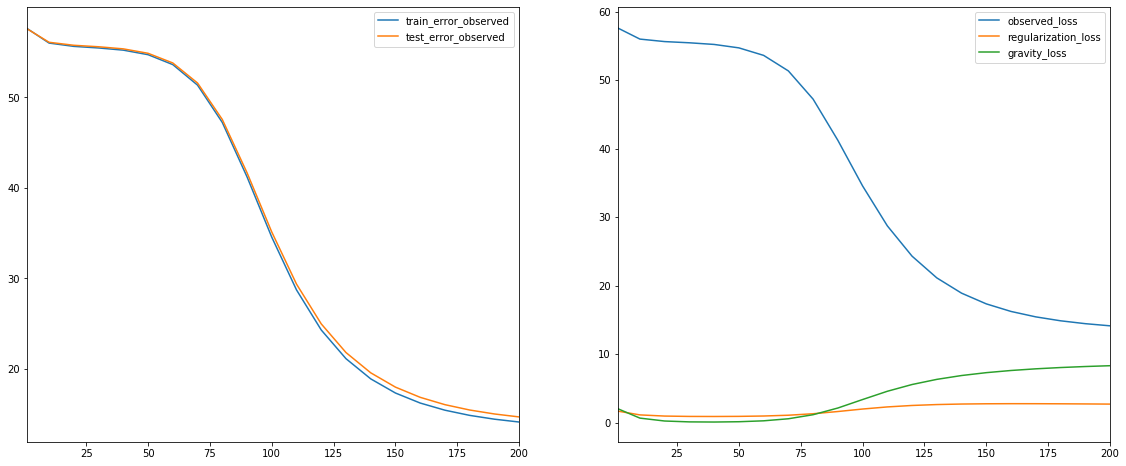

In [51]:
reg_model = build_regularized_model(
    ratings, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35,
    init_stddev=0.5)
reg_model.train(num_iterations=200, learning_rate=20.)

In [58]:
game_neighbors(reg_model, "among_stars", DOT, k=10)

Nearest neighbors of : among_stars.


,dot score,titles
59,31.627075,android_netrunner
502,30.381916,game_thrones_card_game_second_edition
466,30.129421,port_royal
99,29.959900,roll_galaxy
165,29.389627,village
646,29.248009,among_stars
15,27.975840,7_wonders_duel
217,27.722414,bora_bora
361,27.501568,firefly_game
299,27.481592,die_macher


In [65]:
game_neighbors(reg_model, "roll_player", COSINE, k=10)

Nearest neighbors of : roll_player.


,cosine score,titles
374,1.000000,spartacus_game_blood_and_treachery
606,0.999489,arcadia_quest_inferno
361,0.999440,firefly_game
466,0.999395,port_royal
59,0.999389,android_netrunner
99,0.999384,roll_galaxy
165,0.999358,village
299,0.999356,die_macher
502,0.999340,game_thrones_card_game_second_edition
646,0.999312,among_stars


# Softmax Model

In [2]:
# Currently not working, so I am setting arbitrary false code to stop the program before it gets here
assert(2==1)

AssertionError: 

In [ ]:
rated_games = (ratings[["user_idx", "game_idx"]]
                .groupby("user_idx", as_index=False)
                .aggregate(lambda x: list(x)))
rated_games.head()

In [ ]:
games['year'] = games['year'].astype(int)
games = games.merge(full_genre_list, on = ['game_idx'], how= 'left')
games.rename(columns = {'genre_x': 'genre', 'genre_y': 'all_genres'}, inplace=True)
games['all_genres'].fillna('NA', inplace=True)
games['year'] = games['year'].astype(str)
games['game_idx'] = games['game_idx'].astype(str)

In [ ]:
#title Batch generation code (run this cell)
years_dict = {
    game: year for game, year in zip(games["game_idx"], games["year"])
}
genres_dict = {
#     game: genres.split(';')
#     for game, genres in zip(games["game_idx"], games["genre"])
    game : year for game, year in zip(games["game_idx"], games["genre"])
}

In [ ]:
def make_batch(ratings, batch_size):
  """Creates a batch of examples.
  Args:
    ratings: A DataFrame of ratings such that examples["movie_id"] is a list of
      movies rated by a user.
    batch_size: The batch size.
  """
  def pad(x, fill):
    print("padding")
    return pd.DataFrame.from_dict(x).fillna(fill).values

  game = []
  year = []
  genre = []
  label = []
  for game_ids in ratings["game_idx"].values:
    game.append(game_ids)
    #genre.append([x for game_id in game_ids for x in genres_dict[str(game_id)]])
    genre.append([genres_dict[str(game_id)] for game_id in game_ids])
    year.append([years_dict[str(game_id)] for game_id in game_ids])
    label.append([int(game_id) for game_id in game_ids])
  print('finished intital loop')

  features = {
      "game_id": pad(game, ""),
      "year": pad(year, ""),
      "genre": pad(genre, ""),
      "label": pad(label, -1)
  }
  print('created features', features.shape)
  batch = (
      tf.data.Dataset.from_tensor_slices(features)
      .shuffle(1000)
      .repeat()
      .batch(batch_size)
      .make_one_shot_iterator()
      .get_next())
  return batch

In [ ]:
def select_random(x):
  """Selectes a random elements from each row of x."""
  def to_float(x):
    return tf.cast(x, tf.float32)
  def to_int(x):
    return tf.cast(x, tf.int64)
  batch_size = tf.shape(x)[0]
  rn = tf.range(batch_size)
  nnz = to_float(tf.count_nonzero(x >= 0, axis=1))
  rnd = tf.random_uniform([batch_size])
  ids = tf.stack([to_int(rn), to_int(nnz * rnd)], axis=1)
  return to_int(tf.gather_nd(x, ids))

In [ ]:
def softmax_loss(user_embeddings, game_embeddings, labels):
  """Returns the cross-entropy loss of the softmax model.
  Args:
    user_embeddings: A tensor of shape [batch_size, embedding_dim].
    movie_embeddings: A tensor of shape [num_movies, embedding_dim].
    labels: A tensor of [batch_size], such that labels[i] is the target label
      for example i.
  Returns:
    The mean cross-entropy loss.
  """
  # Verify that the embddings have compatible dimensions
  user_emb_dim = user_embeddings.shape[1].value
  game_emb_dim = game_embeddings.shape[1].value
  if user_emb_dim != movie_emb_dim:
    raise ValueError(
        "The user embedding dimension %d should match the movie embedding "
        "dimension % d" % (user_emb_dim, movie_emb_dim))

  logits = tf.matmul(user_embeddings, game_embeddings, transpose_b=True)
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
      logits=logits, labels=labels))
  return loss

In [ ]:
def build_softmax_model(rated_games, embedding_cols, hidden_dims):
  """Builds a Softmax model for gameLens.
  Args:
    rated_games: DataFrame of traing examples.
    embedding_cols: A dictionary mapping feature names (string) to embedding
      column objects. This will be used in tf.feature_column.input_layer() to
      create the input layer.
    hidden_dims: int list of the dimensions of the hidden layers.
  Returns:
    A CFModel object.
  """
  def create_network(features):
    """Maps input features dictionary to user embeddings.
    Args:
      features: A dictionary of input string tensors.
    Returns:
      outputs: A tensor of shape [batch_size, embedding_dim].
    """
    # Create a bag-of-words embedding for each sparse feature.
    inputs = tf.feature_column.input_layer(features, embedding_cols)
    # Hidden layers.
    input_dim = inputs.shape[1].value
    for i, output_dim in enumerate(hidden_dims):
      w = tf.get_variable(
          "hidden%d_w_" % i, shape=[input_dim, output_dim],
          initializer=tf.truncated_normal_initializer(
              stddev=1./np.sqrt(output_dim))) / 10.
      outputs = tf.matmul(inputs, w)
      input_dim = output_dim
      inputs = outputs
    return outputs

  train_rated_games, test_rated_games = split_dataframe(rated_games)
  train_batch = make_batch(train_rated_games, 200)
  test_batch = make_batch(test_rated_games, 100)

  with tf.variable_scope("model", reuse=False):
    # Train
    train_user_embeddings = create_network(train_batch)
    train_labels = select_random(train_batch["label"])
  with tf.variable_scope("model", reuse=True):
    # Test
    test_user_embeddings = create_network(test_batch)
    test_labels = select_random(test_batch["label"])
    game_embeddings = tf.get_variable(
        "input_layer/game_id_embedding/embedding_weights")

  test_loss = softmax_loss(
      test_user_embeddings, game_embeddings, test_labels)
  train_loss = softmax_loss(
      train_user_embeddings, game_embeddings, train_labels)
  _, test_precision_at_10 = tf.metrics.precision_at_k(
      labels=test_labels,
      predictions=tf.matmul(test_user_embeddings, game_embeddings, transpose_b=True),
      k=10)

  metrics = (
      {"train_loss": train_loss, "test_loss": test_loss},
      {"test_precision_at_10": test_precision_at_10}
  )
  embeddings = {"game_idx": game_embeddings}
  return CFModel(embeddings, train_loss, metrics)

In [ ]:
# Create feature embedding columns
def make_embedding_col(key, embedding_dim):
  categorical_col = tf.feature_column.categorical_column_with_vocabulary_list(
      key=key, vocabulary_list=list(set(games[key].values)), num_oov_buckets=0)
  return tf.feature_column.embedding_column(
      categorical_column=categorical_col, dimension=embedding_dim,
      # default initializer: trancated normal with stddev=1/sqrt(dimension)
      combiner='mean')

In [ ]:
ratings = ratings[ratings['rating'] >= 10]

In [ ]:
ratings['game_idx'] = ratings['game_idx'].astype(str)
with tf.Graph().as_default():
  softmax_model = build_softmax_model(
      rated_games,
      embedding_cols=[
          make_embedding_col("game_idx", 10),
          make_embedding_col("genre", 3),
          make_embedding_col("year", 2),
      ],
      hidden_dims=[35])

In [ ]:
softmax_model.train(
    learning_rate=8., num_iterations=300, optimizer=tf.train.AdagradOptimizer)

# Scratch Code